In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
import glob
import sys
sys.path.append("../Acdc/")
sys.path.append("../Util/")
sys.path.append("../Analysis/")
sys.path.append("../WaveformPlotter/")
sys.path.append("../")
import Acdc 
import Analysis
import WaveformPlotter
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'error_codes'

# Create dictionaries for loading configurations nicely
### Also define some filepaths that should be adjusted based on your environment

In [1]:
#Structure of this dict:
#key: acdc number
#value: dict with the following keys
#   obj: Acdc object itself
#   config: configuration file path 
#   infiles: list of input data files for that board

#this set of boards is used in the July 2024 proton data at test-beam
acdcs = {44:{"obj":None, "config":"../configs/acdc44.yml", "infiles": [], "pedfiles": []}, \
	43:{"obj":None, "config":"../configs/acdc43.yml", "infiles": [], "pedfiles": []}}

#Configure some data filepaths
#you'll likely want to keep paths as we may be committing/pushing
#multiple paths. Just use a comment
datadir = "../../data/20240701ProtonDataFTBF/"


In [ ]:
#load the waveforms into the events attribute
for acdc_num, a in acdcs.items():
	a["obj"] = Acdc.Acdc(a["config"])

	#the configuration is now parsed, so we can find which station id
	#in order to parse the filetag at the end of the data filenames. 
	bnum = a["obj"].c["station_id"]
	#find all the data files for this board
	a["infiles"] = glob.glob(datadir + f"Raw_Proton*b{bnum}.txt")
	#find all the pedestal files for this board
	a["pedfiles"] = glob.glob(datadir + f"Raw_test*b{bnum}.txt")


	#go file by file and save pre-reduced data for each file.
	#The machinery in the ACDC class can instead handle all files,
	# it is so resource and RAM intensive that I instead opt to save
	#a pre-reduced output file for each input file, looping individually. 
	for f in a["infiles"]:
		#the function can take a list of files, 
		#so I pass just the one we are working on
		a["obj"].load_raw_data_to_events([f]) 

		#loads root file containing linearity data, 
		#calibrates pedestals based on ADC/voltage and does
		#pedestal subtraction, and loads timebase calibration.
		#Within these pedfiles, it finds the closest file to our
		#events without using a future pedfile. 
		a["obj"].calibrate_waveforms(a["pedfiles"])
		a["obj"].write_events_to_file(f.replace(".txt", "_prereduced.p"))




In [2]:
#Loading the pre-reduced data
#load the waveforms into the events attribute
for acdc_num, a in acdcs.items():
    a["obj"] = Acdc.Acdc(a["config"])

    #the configuration is now parsed, so we can find which station id
    #in order to parse the filetag at the end of the data filenames. 
    bnum = a["obj"].c["station_id"]
    if bnum == 1:
        a["obj"].read_events_from_file("../../LAPPDTestData/Raw_ProtonData_20240701_134140_b1_prereduced.p")
    elif bnum == 0:
        a["obj"].read_events_from_file("../../LAPPDTestData/Raw_ProtonData_20240701_134140_b0_prereduced.p")


NameError: name 'Acdc' is not defined

In [17]:
for i in range(256):
    acdcs[43]["obj"].times[0][i] = acdcs[43]["obj"].times[1][i] #In my acdc43.root file, ch 0 is corrupted, so I copy ch 1 to ch 0
for acdc_num, a in acdcs.items():
    a["obj"].reduce_data()

Populated peak times for channel 0
Number of events with non-default peak times for channel 0: 0
Populated peak times for channel 1
Number of events with non-default peak times for channel 1: 3
Populated peak times for channel 2
Number of events with non-default peak times for channel 2: 0
Populated peak times for channel 3
Number of events with non-default peak times for channel 3: 1
Populated peak times for channel 4
Number of events with non-default peak times for channel 4: 0
Populated peak times for channel 5
Number of events with non-default peak times for channel 5: 0
Populated peak times for channel 6
Number of events with non-default peak times for channel 6: 0
Populated peak times for channel 7
Number of events with non-default peak times for channel 7: 0
Populated peak times for channel 8
Number of events with non-default peak times for channel 8: 2
Populated peak times for channel 9
Number of events with non-default peak times for channel 9: 1
Populated peak times for chann

100
26
26
[-1, -1]
-2.9827880011654555
[1109, 1109, 1109, 1109, 1109, 1109]


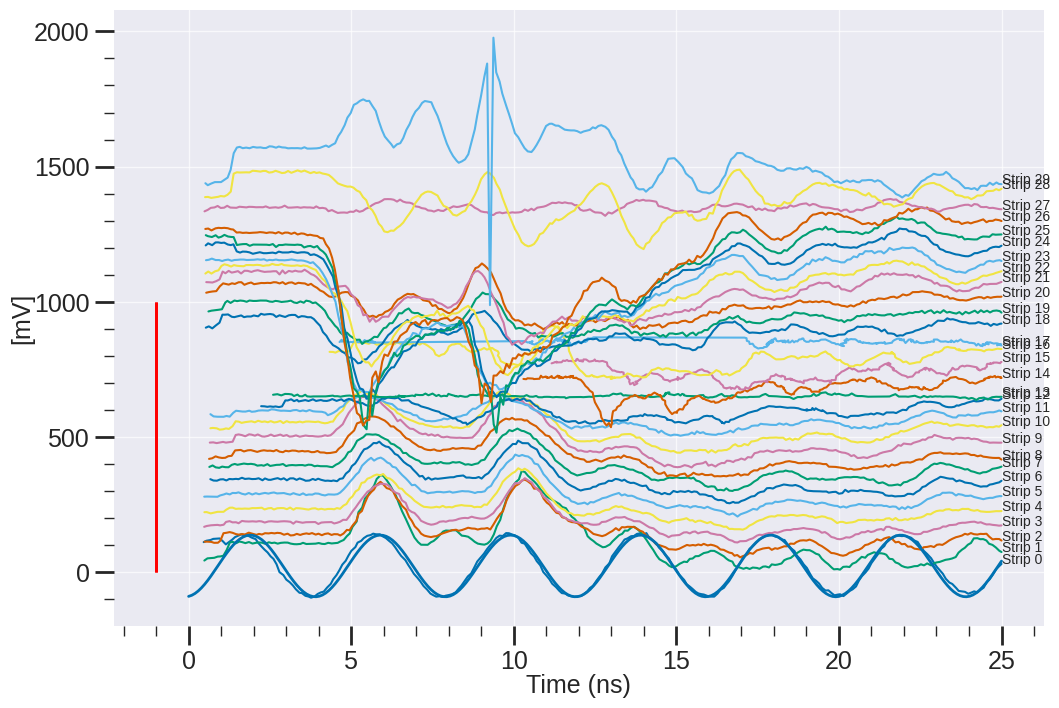

101
21
21
[-1, -1]
-3.5337859950251236
[1109, 1109, 1109, 1109, 1109, 1109]


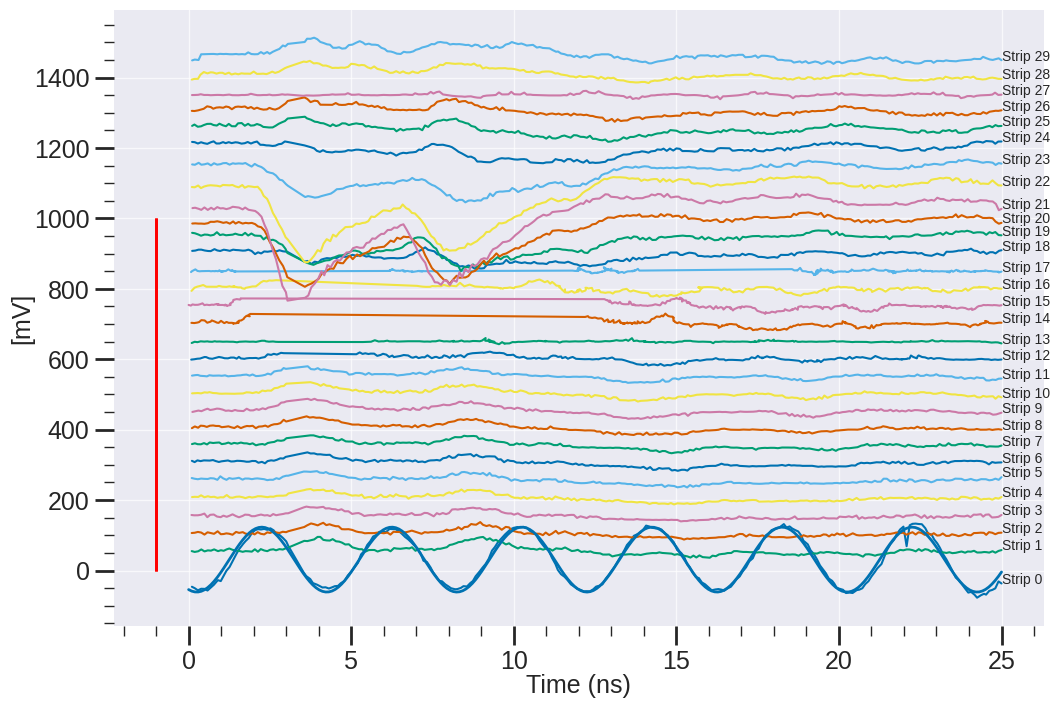

102
21
21
[-1, -1]
1.1618801090574427
[1109, 1109, 1109, 1109, 1109, 1109]


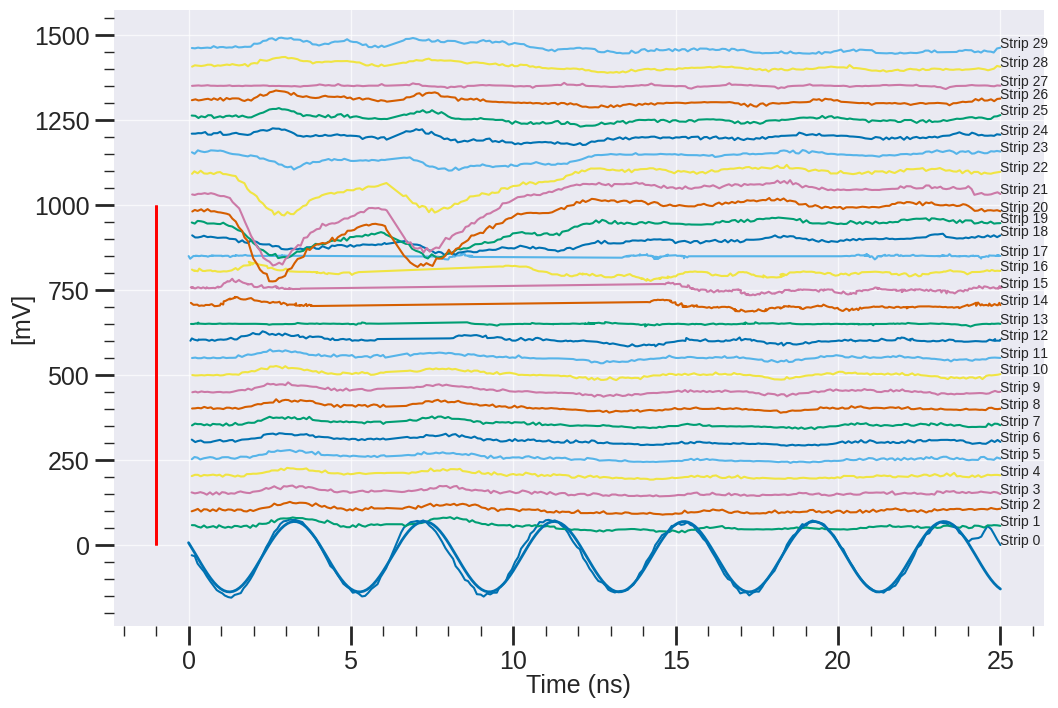

103
25
25
[-1, -1]
-3.082327204830318
[1109, 1109, 1109, 1109, 1109]


KeyboardInterrupt: 

In [18]:
import Util

wp = WaveformPlotter.WaveformPlotter([acdcs[44]["obj"], acdcs[43]["obj"]])

tgt = acdcs[44]["obj"]
#print(acdcs[44]["obj"].times[11])
plt.style.use("~/evanstyle.mplstyle") #change this if you want! or comment
plt.close()
for ev in range(100, 150):
    if(tgt.rqs["time_measured_ch"][ev]!= 0):
        fig, ax = wp.plot_waveforms_separated(station_id=0, event_number=ev)
        plt.vlines(tgt.events["ch{}_peak_times".format(int(tgt.rqs["time_measured_ch"][ev]))][ev], 0, 1000, color="red")
        print(ev)
        print(int(tgt.rqs["time_measured_ch"][ev]))
        print(int(tgt.rqs["peak_ch"][ev]))
        print(tgt.events["ch{}_peak_times".format(int(tgt.rqs["time_measured_ch"][ev]))][ev])
        print(tgt.rqs["wr_phi"][ev])
        print(tgt.rqs["error_codes"][ev])
        plt.plot(np.linspace(0, 25, 256), np.sin(np.linspace(0, 25, 256)/2*np.pi+tgt.rqs["wr_Phi0"][ev])*tgt.rqs["wr_Amplitude"][ev] + tgt.rqs["wr_Offset"][ev])
        #plt.savefig("../../plots/example_waveforms/{:d}_b0.png".format(i))
        plt.show()

#plt.plot(np.linspace(0, 25, 256), tgt.events["waves"][1100][11])

In [ ]:
an = Analysis.Analysis("../configs/analysis.yml", acdcs)
c, s = an.construct_coincidence(acdcs[44]["obj"], acdcs[43]["obj"])
print(str(s)+" seconds difference between the WR PPS counter of the two stations.")
plt.hist(np.transpose(np.array(c))[2], bins=20)
plt.xlabel("Time Difference $t_2 - t_1$ (ns)")
plt.ylabel("# of Coincidence Pairs")
plt.title("Subsecond WR Counter Comparison Between Two Stations, After Coincidence Cut")
plt.show()


construct_coincidence found 3328 coincidences.
[[1, 2], [], [1], [1, 2], [1], [1], [1], ..., [], [], [2], [1, 2], [], [2], [2]]


Text(0.5, 1.0, 'WR Sine Phase Comparison Between Two Stations, After Coincidence Cut')

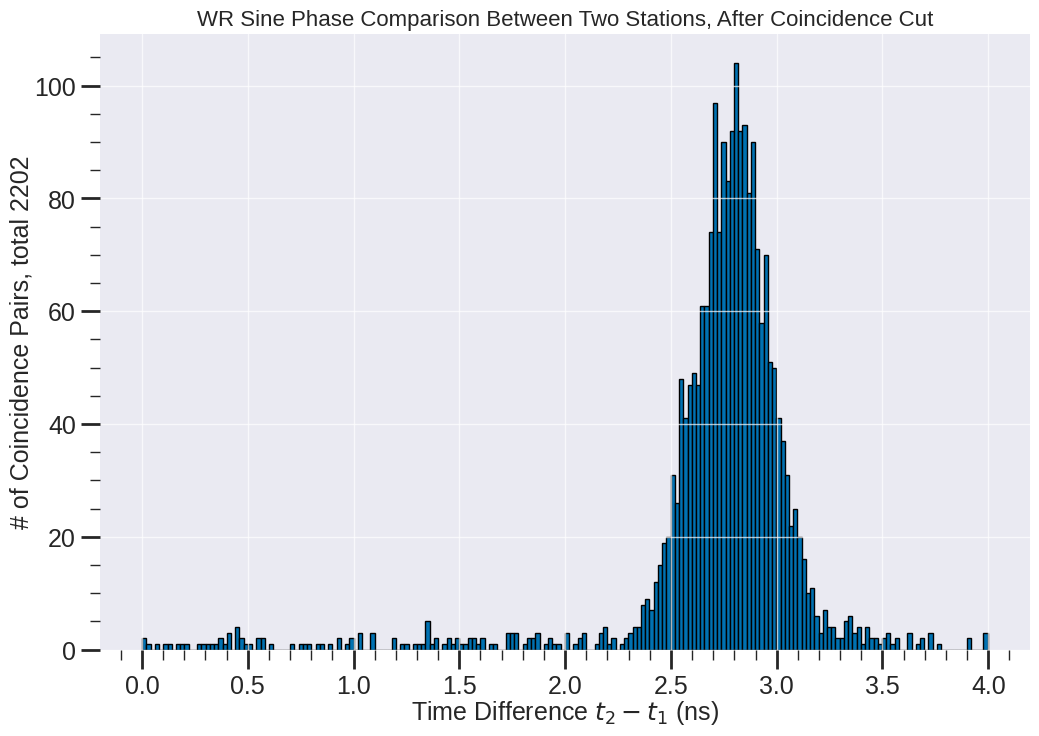

In [9]:
an = Analysis.Analysis("../configs/analysis.yml", acdcs)
an.construct_tracks(acdcs[44]["obj"], acdcs[43]["obj"])
print(an.tracks["error_codes"])
error_mask = [len(an.tracks["error_codes"][trk])==0 for trk in range(len(an.tracks["error_codes"]))]
plt.hist(an.tracks["time_of_flight_ns"][error_mask], bins=200)
plt.xlabel("Time Difference $t_2 - t_1$ (ns)")
plt.ylabel("# of Coincidence Pairs, total {}".format(np.count_nonzero(error_mask)))
plt.title("WR Sine Phase Comparison Between Two Stations, After Coincidence Cut")

In [ ]:
for acdc_num, a in acdcs.items():
    a["obj"].reconstruct_peak_time()
    a["obj"].construct_wr_phi(verbose=True)

In [ ]:
# for ch in range(30):
#     print(np.count_nonzero(acdcs[43]["obj"].events["ch{}_is_hit".format(ch)]))

for ev, is_hit in enumerate(acdcs[43]["obj"].events["ch{}_is_hit".format(10)]):
    if is_hit:
        print(ev)